In [2]:
#basic imports and env
import os
from dotenv import load_dotenv
load_dotenv()
api_key = os.getenv('paid_sec_api_key')

In [3]:
import libs.sec_fin_statement_helpers as sec_fin

In [4]:
import requests
import json
import pandas as pd
import libs.sec as sec

# Pull URLs
filing_url_df = pd.read_csv('.\Data\Cleaned_Data\sec_url_df.csv',index_col=0)
filing_url_df

,ticker,periodOfReport,linkToFilingDetails,formType,cik
0,NFLX,2022-03-31,https://www.sec.gov/Archives/edgar/data/106528...,10-Q,1065280
1,NFLX,2021-09-30,https://www.sec.gov/Archives/edgar/data/106528...,10-Q,1065280
2,NFLX,2021-06-30,https://www.sec.gov/Archives/edgar/data/106528...,10-Q,1065280
3,NFLX,2021-03-31,https://www.sec.gov/Archives/edgar/data/106528...,10-Q,1065280
4,NFLX,2020-09-30,https://www.sec.gov/Archives/edgar/data/106528...,10-Q,1065280
...,...,...,...,...,...
511,MELI,2012-12-31,https://www.sec.gov/Archives/edgar/data/109959...,10-K,1099590
512,SOFI,2021-12-31,https://www.sec.gov/Archives/edgar/data/181887...,10-K/A,1818874
513,SOFI,2021-12-31,https://www.sec.gov/Archives/edgar/data/181887...,10-K,1818874
514,SOFI,2020-12-31,https://www.sec.gov/Archives/edgar/data/181887...,10-K/A,1818874


In [5]:
# XBRL-to-JSON converter API endpoint
xbrl_converter_api_endpoint = "https://api.sec-api.io/xbrl-to-json"

Can Pull:

RevenueFromContractWithCustomerExcludingAssessedTax, CostOfGoodsAndServicesSold, GrossProfit, ResearchAndDevelopmentExpense, SellingGeneralAndAdministrativeExpense, OperatingExpenses, OperatingIncomeLoss, NonoperatingIncomeExpense, IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest, IncomeTaxExpenseBenefit, NetIncomeLoss, EarningsPerShareBasic, EarningsPerShareDiluted, WeightedAverageNumberOfSharesOutstandingBasic, WeightedAverageNumberOfDilutedSharesOutstanding

In [6]:
from sec_api import QueryApi
# get your API key at https://sec-api.io
query_api = QueryApi(api_key=api_key)

In [7]:
ticker_list = pd.read_csv("./Data/Cleaned_Data/Ticker_library.csv")["Ticker"].to_list()

In [8]:
def SEC_filings_query(ticker_list,filingTypes:list):
    filings_dict = {}
    for ticker in ticker_list:
        filings=[]
        for fileType in filingTypes:
            query = {
                "query": { "query_string": { 
                    "query": f"ticker:{ticker} AND filedAt:"+"{2012-06-01 TO 2022-06-01} AND formType:\""+f"{fileType}\"" 
                } },
                "from": "0",
                "size": "60",
                "sort": [{ "filedAt": { "order": "desc" } }]
            }
            filings.extend(query_api.get_filings(query)['filings'])
        filings_dict[ticker] = filings
    return filings_dict

In [9]:
all_filings = SEC_filings_query(ticker_list,['10-Q','10-k'])

In [10]:
accession_numbers = {}

# extract accession numbers of each filing
for ticker in ticker_list:
    accessionNums = []
    for filing in all_filings[ticker]:
        accessionNums.append(filing['accessionNo'])
    accession_numbers[ticker] = accessionNums

accession_numbers

{'NFLX': ['0001065280-22-000145',
  '0001065280-21-000363',
  '0001065280-21-000250',
  '0001065280-21-000144',
  '0001065280-20-000451',
  '0001065280-20-000309',
  '0001065280-20-000155',
  '0001065280-19-000368',
  '0001065280-19-000260',
  '0001065280-19-000157',
  '0001065280-18-000538',
  '0001065280-18-000360',
  '0001065280-18-000205',
  '0001065280-17-000180',
  '0001065280-17-000046',
  '0001628280-17-003939',
  '0001065280-16-000081',
  '0001065280-16-000072',
  '0001065280-16-000057',
  '0001065280-15-000038',
  '0001065280-15-000031',
  '0001065280-15-000017',
  '0001065280-14-000028',
  '0001065280-14-000021',
  '0001065280-14-000012',
  '0001065280-13-000036',
  '0001065280-13-000030',
  '0001065280-13-000020',
  '0001065280-12-000023',
  '0001065280-12-000020',
  '0001065280-12-000012',
  '0001065280-22-000036',
  '0001065280-21-000040',
  '0001065280-20-000040',
  '0001065280-19-000079',
  '0001065280-19-000043',
  '0001628280-18-000941',
  '0001065280-18-000069',
  '0

In [13]:
# from IPython.display import display, HTML
def create_final_income_statement(ticker_accession_numbers):
    # helps printing dataframes while we generate new income statement
    previous_income_statement_set = False
    income_statement_final = None

    for accession_no in ticker_accession_numbers:
    # for accession_no in accession_numbers: # doesn't work with filings filed before 2017 - indicies not equal
        print('Processing: ' + accession_no)
        try:
            # get XBRL-JSON of 10-Q or 10-K filing by accession number
            xbrl_json_data = sec_fin.get_xbrl_json(accession_no)
            
            # convert XBRL-JSON to a pandas dataframe
            income_statement_uncleaned = sec_fin.get_income_statement(xbrl_json_data)

            # clean the income statement
            income_statement_cleaned = sec_fin.clean_income_statement(income_statement_uncleaned)
            
            # print income statement on each iteration to monitor progress
            # display(HTML(income_statement_cleaned.to_html()))
            
            # merge new income statement with previously generated income statement
            if previous_income_statement_set:
                income_statement_final = sec_fin.clean_income_statement(sec_fin.merge_income_statements(income_statement_final, income_statement_cleaned))
            else:
                income_statement_final = income_statement_cleaned
                previous_income_statement_set = True
        except:
            continue
    return income_statement_final
def create_final_income_statement_df(accession_numbers_dict):
    df_dict = {}
    for ticker in accession_numbers_dict.keys():
        print(f'Start Processing: {ticker}')
        try:
            ticker_df = create_final_income_statement(accession_numbers[ticker]).transpose().reset_index()
            ticker_df.rename(columns={0:"Dates"})
            ticker_df['Ticker']=ticker #add Column name
            df_dict[ticker] = ticker_df
        except:
            continue
    return df_dict
income_statement_final = create_final_income_statement_df(accession_numbers)

Start Processing: NFLX
Processing: 0001065280-22-000145
Processing: 0001065280-21-000363
Processing: 0001065280-21-000250
Processing: 0001065280-21-000144
Processing: 0001065280-20-000451
Processing: 0001065280-20-000309
Processing: 0001065280-20-000155
Processing: 0001065280-19-000368
Processing: 0001065280-19-000260
Processing: 0001065280-19-000157
Processing: 0001065280-18-000538
Processing: 0001065280-18-000360
Processing: 0001065280-18-000205
Processing: 0001065280-17-000180
Processing: 0001065280-17-000046
Processing: 0001628280-17-003939
Processing: 0001065280-16-000081
Processing: 0001065280-16-000072
Processing: 0001065280-16-000057
Processing: 0001065280-15-000038
Processing: 0001065280-15-000031
Processing: 0001065280-15-000017
Processing: 0001065280-14-000028
Processing: 0001065280-14-000021
Processing: 0001065280-14-000012
Processing: 0001065280-13-000036
Processing: 0001065280-13-000030
Processing: 0001065280-13-000020
Processing: 0001065280-12-000023
Processing: 00010652

In [14]:
#Processing: 0001628280-18-006982
income_statement_final

{'NFLX': Empty DataFrame
 Columns: [index, Revenues, CostOfRevenue, MarketingExpense, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, GeneralAndAdministrativeExpense, OperatingIncomeLoss, InterestExpense, IncomeTaxExpenseBenefit, NetIncomeLoss, EarningsPerShareBasic, EarningsPerShareDiluted, WeightedAverageNumberOfSharesOutstandingBasic, WeightedAverageNumberOfDilutedSharesOutstanding, nan, IncomeLossFromContinuingOperationsBeforeIncomeTaxesMinorityInterestAndIncomeLossFromEquityMethodInvestments, ResearchAndDevelopmentExpense, nan, OtherNonoperatingIncome, Ticker]
 Index: []
 
 [0 rows x 31 columns],
 'FB': Empty DataFrame
 Columns: [index, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, CostOfRevenue, ResearchAndDevelopmentExpense, SellingAndMarketingExpense, GeneralAndAdministrativeExpense, CostsAndExpenses, OperatingIncomeLoss, IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest, IncomeTaxExpenseBenefit, NetIncomeLoss,

In [15]:
for ticker in income_statement_final.keys():
    income_statement_final[ticker].to_csv(f'.\Data\Cleaned_Data\SEC_Fin_Data\{ticker}_SEC_Fin_data')

In [ ]:
# The below lines will not run
# need to remove ticker and transpose the dfs to be able to run sec_fin.add_fourth_quarter_results() and .only_quarterly_results()

statement = income_statement_final
statement_1 = sec_fin.add_fourth_quarter_results(statement)

In [ ]:
statement_1

,2016-09-25-2017-09-30,2017-10-01-2018-06-30,2017-10-01-2018-09-29,2018-04-01-2018-06-30,2018-06-30-2018-09-29,2018-09-30-2018-12-29,2018-09-30-2019-03-30,2018-09-30-2019-06-29,2018-09-30-2019-09-28,2018-12-30-2019-03-30,...,2020-09-27-2020-12-26,2020-09-27-2021-03-27,2020-09-27-2021-06-26,2020-09-27-2021-09-25,2020-12-27-2021-03-27,2021-03-28-2021-06-26,2021-06-26-2021-09-25,2021-09-26-2021-12-25,2021-09-26-2022-03-26,2021-12-26-2022-03-26
RevenueFromContractWithCustomerExcludingAssessedTax,229234000000,202695000000,265595000000,53265000000,62900000000,84310000000,142325000000,196134000000,260174000000,58015000000,...,111439000000,201023000000,282457000000,365817000000,89584000000,81434000000,83360000000,123945000000,221223000000,97278000000
CostOfGoodsAndServicesSold,141048000000,124940000000,163756000000,32844000000,38816000000,52279000000,88473000000,122055000000,161782000000,36194000000,...,67111000000,118616000000,164795000000,212981000000,51505000000,46179000000,48186000000,69702000000,124421000000,54719000000
GrossProfit,88186000000,77755000000,101839000000,20421000000,24084000000,32031000000,53852000000,74079000000,98392000000,21821000000,...,44328000000,82407000000,117662000000,152836000000,38079000000,35255000000,35174000000,54243000000,96802000000,42559000000
ResearchAndDevelopmentExpense,11581000000,10486000000,14236000000,3701000000,3750000000,3902000000,7850000000,12107000000,16217000000,3948000000,...,5163000000,10425000000,16142000000,21914000000,5262000000,5717000000,5772000000,6306000000,12693000000,6387000000
SellingGeneralAndAdministrativeExpense,15261000000,12489000000,16705000000,4108000000,4216000000,4783000000,9241000000,13667000000,18245000000,4458000000,...,5631000000,10945000000,16357000000,21973000000,5314000000,5412000000,5616000000,6449000000,12642000000,6193000000
OperatingExpenses,26842000000,22975000000,30941000000,7809000000,7966000000,8685000000,17091000000,25774000000,34462000000,8406000000,...,10794000000,21370000000,32499000000,43887000000,10576000000,11129000000,11388000000,12755000000,25335000000,12580000000
OperatingIncomeLoss,61344000000,54780000000,70898000000,12612000000,16118000000,23346000000,36761000000,48305000000,63930000000,13415000000,...,33534000000,61037000000,85163000000,108949000000,27503000000,24126000000,23786000000,41488000000,71467000000,29979000000
NonoperatingIncomeExpense,2745000000,1702000000,2005000000,672000000,303000000,560000000,938000000,1305000000,1807000000,378000000,...,45000000,553000000,796000000,258000000,508000000,243000000,-538000000,-247000000,-87000000,160000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,64089000000,56482000000,72903000000,13284000000,16421000000,23906000000,37699000000,49610000000,65737000000,13793000000,...,33579000000,61590000000,85959000000,109207000000,28011000000,24369000000,23248000000,41241000000,71380000000,30139000000
IncomeTaxExpenseBenefit,15738000000,11076000000,13372000000,1765000000,2296000000,3941000000,6173000000,8040000000,10481000000,2232000000,...,4824000000,9205000000,11830000000,14527000000,4381000000,2625000000,2697000000,6611000000,11740000000,5129000000


In [ ]:
qrt_income_statement = sec_fin.only_quarterly_results(statement_1)
qrt_income_statement

,2018-04-01-2018-06-30,2018-06-30-2018-09-29,2018-09-30-2018-12-29,2018-12-30-2019-03-30,2019-03-31-2019-06-29,2019-06-29-2019-09-28,2019-09-29-2019-12-28,2019-12-29-2020-03-28,2020-03-29-2020-06-27,2020-06-27-2020-09-26,2020-09-27-2020-12-26,2020-12-27-2021-03-27,2021-03-28-2021-06-26,2021-06-26-2021-09-25,2021-09-26-2021-12-25,2021-12-26-2022-03-26
RevenueFromContractWithCustomerExcludingAssessedTax,53265000000,62900000000,84310000000,58015000000,53809000000,64040000000,91819000000,58313000000,59685000000,64698000000,111439000000,89584000000,81434000000,83360000000,123945000000,97278000000
CostOfGoodsAndServicesSold,32844000000,38816000000,52279000000,36194000000,33582000000,39727000000,56602000000,35943000000,37005000000,40009000000,67111000000,51505000000,46179000000,48186000000,69702000000,54719000000
GrossProfit,20421000000,24084000000,32031000000,21821000000,20227000000,24313000000,35217000000,22370000000,22680000000,24689000000,44328000000,38079000000,35255000000,35174000000,54243000000,42559000000
ResearchAndDevelopmentExpense,3701000000,3750000000,3902000000,3948000000,4257000000,4110000000,4451000000,4565000000,4758000000,4978000000,5163000000,5262000000,5717000000,5772000000,6306000000,6387000000
SellingGeneralAndAdministrativeExpense,4108000000,4216000000,4783000000,4458000000,4426000000,4578000000,5197000000,4952000000,4831000000,4936000000,5631000000,5314000000,5412000000,5616000000,6449000000,6193000000
OperatingExpenses,7809000000,7966000000,8685000000,8406000000,8683000000,8688000000,9648000000,9517000000,9589000000,9914000000,10794000000,10576000000,11129000000,11388000000,12755000000,12580000000
OperatingIncomeLoss,12612000000,16118000000,23346000000,13415000000,11544000000,15625000000,25569000000,12853000000,13091000000,14775000000,33534000000,27503000000,24126000000,23786000000,41488000000,29979000000
NonoperatingIncomeExpense,672000000,303000000,560000000,378000000,367000000,502000000,349000000,282000000,46000000,126000000,45000000,508000000,243000000,-538000000,-247000000,160000000
IncomeLossFromContinuingOperationsBeforeIncomeTaxesExtraordinaryItemsNoncontrollingInterest,13284000000,16421000000,23906000000,13793000000,11911000000,16127000000,25918000000,13135000000,13137000000,14901000000,33579000000,28011000000,24369000000,23248000000,41241000000,30139000000
IncomeTaxExpenseBenefit,1765000000,2296000000,3941000000,2232000000,1867000000,2441000000,3682000000,1886000000,1884000000,2228000000,4824000000,4381000000,2625000000,2697000000,6611000000,5129000000


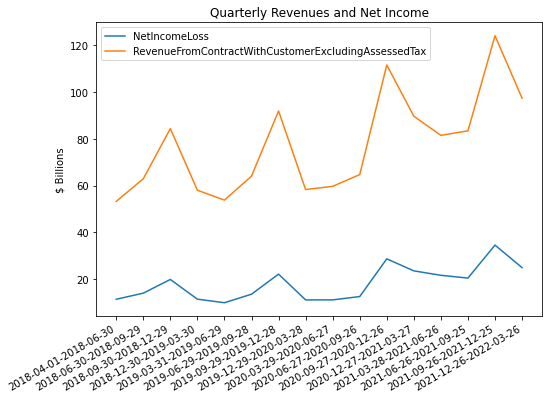

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import numpy as np

# custom y axis formatter
def format_dollars(y, pos=None):
    return int(y/1000000000)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax = qrt_income_statement.astype(float)\
                         .loc["NetIncomeLoss"]\
                         .plot.line(legend=True)
ax = qrt_income_statement.astype(float)\
                         .loc["RevenueFromContractWithCustomerExcludingAssessedTax"]\
                         .plot.line(legend=True)

ax.set_title('Quarterly Revenues and Net Income')

ax.yaxis.set_major_formatter(tick.FuncFormatter(format_dollars))

plt.ylabel('$ Billions')

# show all quarter date ranges
plt.xticks(ticks=np.arange(len(qrt_income_statement.columns)),
           labels=qrt_income_statement.columns)

# format x axis properly
fig.autofmt_xdate()

plt.show()

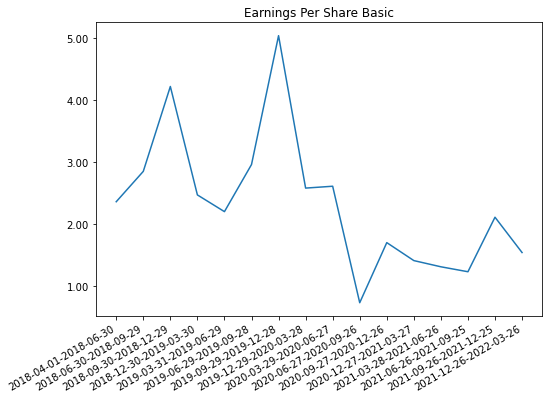

In [ ]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax = qrt_income_statement.astype(float).loc["EarningsPerShareBasic"].plot.line()

ax.set_title('Earnings Per Share Basic')

# use higher precision for y axis labels
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.xticks(ticks=np.arange(len(qrt_income_statement.columns)),
           labels=qrt_income_statement.columns)

# format x axis properly
fig.autofmt_xdate()

plt.show()